In [2]:
import google.generativeai as genai
from IPython.display import HTML, Markdown, display
from dotenv import load_dotenv
import os

/home/supreet/projects/gemini_hands_on/.conda/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
load_dotenv()

True

LangGraph applications are built around a graph structure\
The app will define a state schema, and an instance of that schema is propagated through the graph.\
Each node in the graph represents an action or step that can be taken. Nodes will make changes to the state in some way through code that you define. \
Each edge in the graph represents a transition between states, defining the flow of the program. 

# State

Here we define a state object, ```OrderState```, that holds the conversation history, a structured order, and a flag indicating if the customer has finished placing their order.\
The LangGraph state object is a Python dictionary. We can provide a schema for this dictionary by defining it as a TypedDict

In [5]:


from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""
    
    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]
    
    order: list[str]
    
    finished: bool
    
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!",
)

# Single Turn Chatbot

A chatbot node that will execute a single turn in a chat conversation using the instructions supplied.\
Each node in the graph operates on the state object. The state (a Python dictionary) is passed as a parameter into the node (a function) and the new state is returned. This can be restated as pseudo-code, where state = node(state)

In [21]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI


llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash-latest")

def chatbot(state: OrderState)-> OrderState:
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

graph_builder = StateGraph(OrderState)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")

graph = graph_builder.compile()

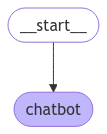

In [22]:
from IPython.display import Image, display

Image(graph.get_graph().draw_mermaid_png())

In [23]:
user = "Hello, what's happening?"

state = graph.invoke({"messages": [user]})

for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what's happening?
AIMessage: Hello! Welcome to BaristaBot Cafe!  What can I get for you today?  We have a wide variety of coffees, teas, and pastries. Would you like to see our menu?



In [24]:
user_msg = "Oh Great. I would love a Coffee. What kind you got"

state["messages"].append(user_msg)

state = graph.invoke(state)

for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, what's happening?
AIMessage: Hello! Welcome to BaristaBot Cafe!  What can I get for you today?  We have a wide variety of coffees, teas, and pastries. Would you like to see our menu?

HumanMessage: Oh Great. I would love a Coffee. What kind you got
AIMessage: We have a selection of coffees!  We offer:

* **Espresso:** A rich, concentrated shot of coffee.
* **Americano:** Espresso diluted with hot water.
* **Cappuccino:** Espresso with steamed milk and a thin layer of foam.
* **Latte:** Espresso with steamed milk and a small amount of foam.
* **Macchiato:** Espresso marked with a dollop of foamed milk.


What kind of coffee would you like?



# Adding Human Node

Expanding the graph. Adding Human node, it will display the last message from the LLM to the user, and then prompt them for their next input. 

In [29]:
from langchain_core.messages.ai import AIMessage

def human_node(state: OrderState)->OrderState:
    last_msg = state['messages'][-1]
    print(f"Model: {last_msg.content}")
    
    user_input=input("User:")
    
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True
    
    return state | {"messages": [("user", user_input)]}

WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

def chatbot_with_welcome_message(state: OrderState)->OrderState:
    if state["messages"]:
        new_messages = llm.invoke(BARISTABOT_SYSINT+state["messages"])
    else:
        new_messages = AIMessage(content=WELCOME_MSG)
        
    return state | {"messages": [new_messages]}

graph_builder = StateGraph(OrderState)

# Add the chatbot and human nodes to the app graph.
graph_builder.add_node("chatbot", chatbot_with_welcome_message)
graph_builder.add_node("human", human_node)

# Start with the chatbot again.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human");


### Conditional Edge
For now there is an edge between chatbot and human and the graph will cycle forever as there is no exit condition. We add a Conditional Edge functions take the state as input, and return a string representing the name of the node to which it will transition.

In [30]:
from typing import Literal

def maybe_exit_human_node(state: OrderState)->Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "chatbot"

In [31]:
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

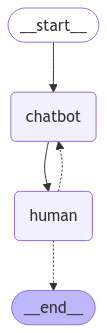

In [32]:
Image(chat_with_human_graph.get_graph().draw_mermaid_png())

In [ ]:
from pprint import pprint
state = chat_with_human_graph.invoke({"messages": []})
pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
